In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -r requirements.txt

## 1. Load data and explore it

Import libraries and fix seed for reproducibility:

In [3]:
import random
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
from torchvision.utils import make_grid
import torch as torch

SEED = 42
random.seed(0)
np.random.seed(0)
torch.manual_seed(SEED)

In [4]:
BASEDIR = "./archive"

DIR_TRAIN = f"{BASEDIR}/train/"
DIR_VALID = f"{BASEDIR}/valid/"
DIR_TEST = f"{BASEDIR}/test/"

In [ ]:
# Remove duplicated space
!mv f'{DIR_VALID}/BLACK & YELLOW  BROADBILL' f'{DIR_VALID}/BLACK & YELLOW BROADBILL'

In [6]:
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ", len(classes))

train_count = 0
valid_count = 0
test_count = 0
for _class in classes:
    train_count += len(os.listdir(os.path.join(DIR_TRAIN, _class)))
    valid_count += len(os.listdir(os.path.join(DIR_VALID, _class)))
    test_count += len(os.listdir(os.path.join(DIR_TEST, _class)))

print("Total train images: ", train_count)
print("Total valid images: ", valid_count)
print("Total test images: ", test_count)

Total Classes:  400
Total train images:  58388
Total valid images:  2000
Total test images:  2000


In [7]:
train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes:
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)

    for img in os.listdir(DIR_VALID + _class):
        valid_imgs.append(DIR_VALID + _class + "/" + img)

    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}

In [8]:
class BirdDataset(Dataset):
    def __init__(self, image_paths, class_to_index, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.class_to_index = class_to_index
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.image_paths[index]

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)

        label = image_path.split("/")[-2]
        label = self.class_to_index[label]

        return image_path, image, label

    def __len__(self):
        return len(self.image_paths)

In [9]:
from torchvision import transforms


def get_train_transform(image_size, pretrained):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        get_normalize_transform(pretrained)
    ])
    return transform

def get_validation_transform(image_size, pretrained):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        get_normalize_transform(pretrained)
    ])
    return transform


def get_normalize_transform(pretrained):
    # Use ImageNet values
    transform = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    return transform

In [10]:
import platform
os = platform.system()

train_dataset = BirdDataset(train_imgs, class_to_int, transform=get_train_transform(224, True))
valid_dataset = BirdDataset(valid_imgs, class_to_int, transform=get_validation_transform(224, True))
test_dataset = BirdDataset(test_imgs, class_to_int, transform=get_validation_transform(224, True))

train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

BATCH_SIZE = 16
# Prevent issues on Windows and Mac. On these systems every subprocess runs script from the start and function parameters are passed by serializing using pickle.
NUM_WORKERS = 4 if os == "Linux" else 0

train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_random_sampler,
)
valid_data_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    sampler=valid_random_sampler,
)

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    sampler=test_random_sampler,
)

Visualize one training batch (without normalization transform).

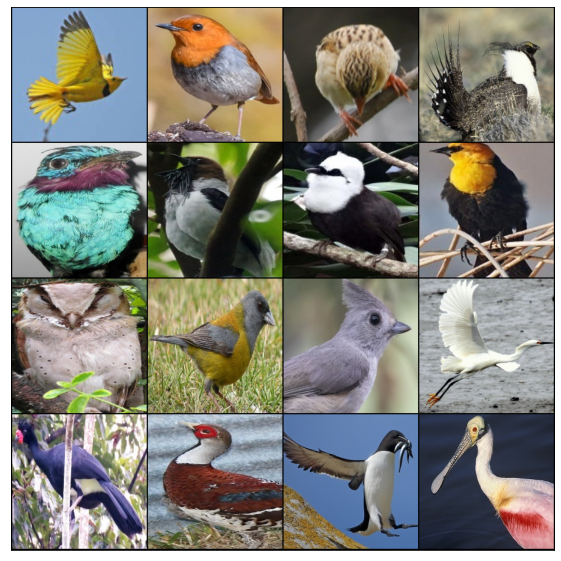

In [11]:
check_dataset = BirdDataset(
    train_imgs,
    class_to_int,
    transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]))
check_random_sampler = RandomSampler(check_dataset)
check_data_loader = DataLoader(
    dataset=check_dataset,
    batch_size=16,
    sampler=check_random_sampler,
)

for _, images, labels in check_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1, 2, 0))
    break

## 2. Train model

### 2.1. Сhoice of neural network architecture

We will choose EfficientNet architecture because:
1. It's among the top models by [image classification rating](https://paperswithcode.com/sota/image-classification-on-imagenet)
2. It has PyTorch implementations which are easy to adapt for fine-tuning.

We will use implementation from torchvision library.
Let's start with EfficientNet-B0 variant.

### 2.2. Architecture recap

EfficientNet is a family of NN architectures build with reasonable size in mind. It starts with baseline B0 architecture, growing to B7 by using *compound scaling* in 3 dimensions: width (number of channels), depth (number of layers) and image resolution.
EfficientNet achieves state-of-the-art results on image classification task by using fewer parameters than other architectures:

![plot](efficientnet.png "EfficientNet accuracy and size")

We can describe baseline B0 model as groups (stages) of convolutional modules:

![model](efficientnet-b0.png "EfficientNet-B0")

B0 architecture was constructed by using *Network architecture search* technique.

Activation function used is *SiLU* (f(x) = x * sigmoid(x)):

<img src="silu.png" alt="SiLU" width="400"/>

Compound scaling can be described as follows:
1. Using baseline model (B0), we search for coefficients alpha, beta and gamma, that determine scaling proportions of depth, width and resolution (d, w, r).
2. Using coefficient for computational power (FLOPS) increase, we find new d, w, r that depend on alpha, beta, gamma.

Authors of original paper used this approach to get all B0-B7 architectures.

Why do we need compound scaling? Intuitively, if we increase image resolution, we need to increase number of channels to better capture fine-grained patterns in image and we also need to increase network depth to increase perceptive field.

### 2.3. Implementation

In [12]:
import torchvision.models as models
import torch.nn as nn


def build_model(pretrained=True, fine_tune=True, num_classes=10):
    if pretrained:
        print('Loading pre-trained weights')
    else:
        print('Not loading pre-trained weights')
    model = models.efficientnet_b0(pretrained=pretrained)

    if fine_tune:
        print('Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

Define logic for saving model and training process visualization:

In [13]:
import torch


def save_model(epochs, model, optimizer, criterion, path_to_checkpoint):
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion,
    }, path_to_checkpoint)

In [14]:
from IPython.core.display_functions import clear_output
import pandas as pd

def exponential_moving_avg(data, span):
    return pd.DataFrame({'data': data})['data'].ewm(span=span).mean().values

def draw_plots(train_acc, valid_acc, train_loss, valid_loss, is_pretrained, scatter_alpha = 0.2):
    figure, (axes_loss, axes_accuracy) = plt.subplots(1, 2, figsize=[20, 10])

    axes_loss.set_title('Loss')
    axes_loss.set_xlabel('Epoch number')
    axes_loss.grid(False)
    axes_loss.scatter(np.arange(len(train_loss)), train_loss, alpha=scatter_alpha, label='train loss')
    axes_loss.plot(exponential_moving_avg(train_loss, span=10))
    axes_loss.scatter(np.arange(len(valid_loss)), valid_loss, alpha=scatter_alpha, label='validation loss')
    axes_loss.plot(exponential_moving_avg(valid_loss, span=10))
    axes_loss.legend()

    axes_accuracy.set_title('Accuracy')
    axes_accuracy.set_xlabel('Epoch number')
    axes_accuracy.grid(False)
    axes_accuracy.scatter(np.arange(len(train_acc)), train_acc, alpha=scatter_alpha, label='train accuracy')
    axes_accuracy.plot(exponential_moving_avg(train_acc, span=10))
    axes_accuracy.scatter(np.arange(len(valid_acc)), valid_acc, alpha=scatter_alpha, label='validation accuracy')
    axes_accuracy.plot(exponential_moving_avg(valid_acc, span=10))
    axes_accuracy.legend()

    plt.show()

In [15]:
from tqdm.auto import tqdm

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_accuracy = 0
    for i, data in tqdm(enumerate(loader), total=len(loader)):
        _, image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_accuracy += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    epoch_loss = train_running_loss / len(loader)
    epoch_acc = 100. * (train_running_accuracy / len(loader.dataset))
    return epoch_loss, epoch_acc

In [16]:
def validate_epoch(model, loader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_accuracy = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader)):
            _, image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            valid_running_accuracy += (preds == labels).sum().item()

    epoch_loss = valid_running_loss / len(loader)
    epoch_acc = 100. * (valid_running_accuracy / len(loader.dataset))
    return epoch_loss, epoch_acc

In [17]:
from torch import optim


def train(model, lr, epochs, path_to_checkpoint, is_pretrained):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train_epoch(model, train_data_loader, optimizer, criterion)
        valid_epoch_loss, valid_epoch_acc = validate_epoch(model, valid_data_loader, criterion)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        print('-' * 50)

    draw_plots(train_acc, valid_acc, train_loss, valid_loss, is_pretrained)
    save_model(epochs, model, optimizer, criterion, path_to_checkpoint)

Visualize model structure.

In [18]:
print(f"Model structure: {build_model(pretrained=False, fine_tune=False, num_classes=len(classes))}\n")

Not loading pre-trained weights
Freezing hidden layers...
Model structure: EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (sc

We can see groups of MBConv layers, each of them wraps several convolution blocks and squeeze-and-excitation block. Our classification layer was appended to the end, as expected.

Let's train model from scratch.

In [19]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


Not loading pre-trained weights
Fine-tuning all layers...
Epoch 1 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 4.951, training acc: 5.386
Validation loss: 3.486, validation acc: 21.600
--------------------------------------------------
Epoch 2 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 3.091, training acc: 30.046
Validation loss: 1.747, validation acc: 55.150
--------------------------------------------------
Epoch 3 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 1.970, training acc: 53.100
Validation loss: 1.022, validation acc: 74.000
--------------------------------------------------
Epoch 4 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 1.407, training acc: 65.709
Validation loss: 0.697, validation acc: 81.750
--------------------------------------------------
Epoch 5 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 1.081, training acc: 72.893
Validation loss: 0.551, validation acc: 85.900
--------------------------------------------------


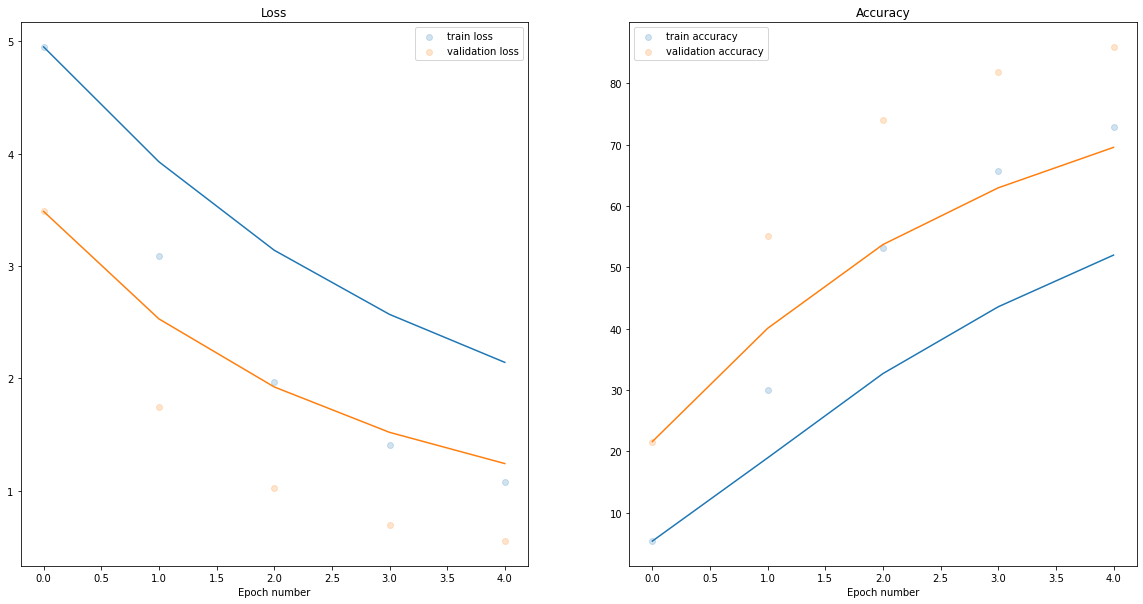

In [20]:
config_train_from_scratch = {
    "lr": 0.001,
    "epochs": 5,
    "path_to_checkpoint": "outputs/model_from_scratch.pth",
    "is_pretrained": False
}

model = build_model(
    pretrained=False,
    fine_tune=True,
    num_classes=len(classes)
).to(device)

train(model, **config_train_from_scratch)

We can see as validation accuracy increases with number of epochs.

Let’s train model from pretrained checkpoint (trained on ImageNet dataset). Decrease learning rate by 10x.

Loading pre-trained weights
Fine-tuning all layers...
Epoch 1 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 1.958, training acc: 66.978
Validation loss: 0.226, validation acc: 95.550
--------------------------------------------------
Epoch 2 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.353, training acc: 92.504
Validation loss: 0.114, validation acc: 97.650
--------------------------------------------------
Epoch 3 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.189, training acc: 95.586
Validation loss: 0.085, validation acc: 97.850
--------------------------------------------------
Epoch 4 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.121, training acc: 97.095
Validation loss: 0.091, validation acc: 97.800
--------------------------------------------------
Epoch 5 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.086, training acc: 97.815
Validation loss: 0.075, validation acc: 98.000
--------------------------------------------------


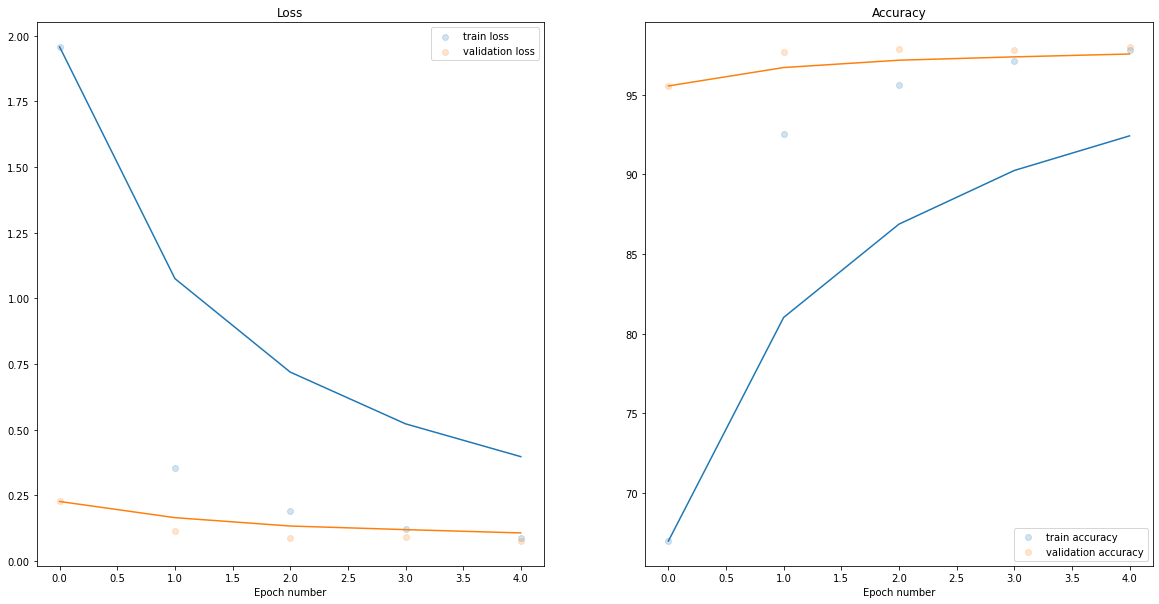

In [21]:
config_fine_tune = {
    "lr": 0.0001,
    "epochs": 5,
    "path_to_checkpoint": "outputs/model_fine_tuned.pth",
    "is_pretrained": True
}

model = build_model(
    pretrained=True,
    fine_tune=True,
    num_classes=len(classes)
).to(device)

train(model, **config_fine_tune)

## 3. Evaluate model

Let's evaluate fine-tuned model, that showed the best accuracy during training.

In [22]:
import torch
import cv2
import numpy as np
from torchvision import transforms

device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(pretrained=False, fine_tune=False, num_classes=len(classes)).to(device)
checkpoint = torch.load('outputs/model_fine_tuned.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

Not loading pre-trained weights
Freezing hidden layers...


<All keys matched successfully>

In [23]:
from sklearn.metrics import classification_report
import torch.nn.functional as F


def get_accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()


def evaluate(model, device, loader, classes):
    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader)):
            _, images, y_true_for_batch = data
            images = images.to(device)
            outputs = model(images)
            _, y_pred_for_batch = torch.max(outputs.data, 1)

            y_pred.append(y_pred_for_batch.cpu())
            y_true.append(y_true_for_batch)

    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    print('Accuracy: ', get_accuracy(y_pred, y_true))
    print('Classification report:')
    print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

In [24]:
evaluate(model, device, test_data_loader, classes)

  0%|          | 0/125 [00:00<?, ?it/s]

Accuracy:  0.9895
Classification report:
                             precision    recall  f1-score   support

            ABBOTTS BABBLER       1.00      0.80      0.89         5
              ABBOTTS BOOBY       1.00      0.80      0.89         5
 ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
      AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
     AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
          AFRICAN FIREFINCH       1.00      1.00      1.00         5
     AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
                  ALBATROSS       1.00      1.00      1.00         5
             ALBERTS TOWHEE       1.00      1.00      1.00         5
       ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
              ALPINE CHOUGH       1.00      1.00      1.00         5
      ALTAMIRA YELLOWTHROAT       1.00      0.80      0.89         5
            AMERICAN AVOCET       1.00      1.00      1.00   

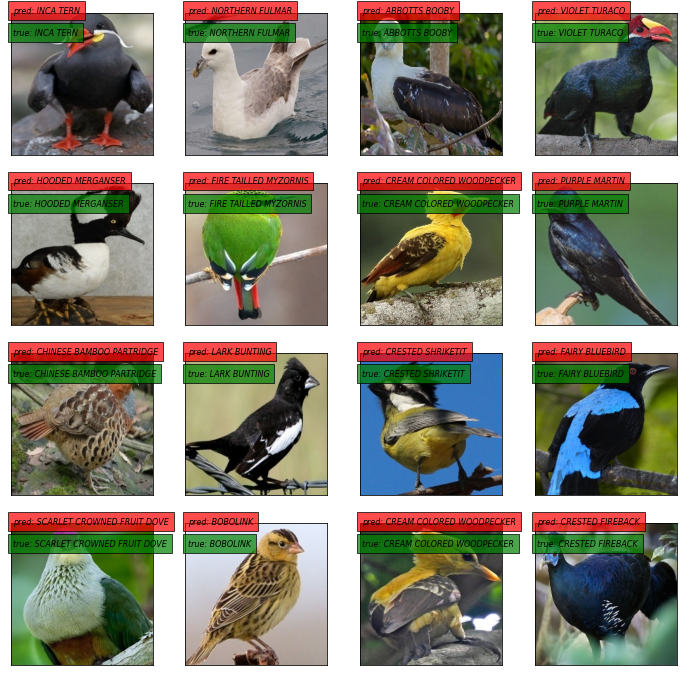

In [25]:
for image_paths, images, labels in test_data_loader:
    images = images.to(device)
    outputs = model(images)
    _, y_pred_for_batch = torch.max(outputs.data, 1)

    original_images = [cv2.imread(image_path) for image_path in image_paths]
    original_images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in original_images]

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()
    for i, (img, ax) in enumerate(zip(original_images, axes)):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(3, 0, f'pred: {classes[y_pred_for_batch[i]]}', style='italic', fontsize=8, bbox={'facecolor': 'red', 'alpha': 0.7, 'pad': 5})
        ax.text(3, 35, f'true: {classes[labels[i]]}', style='italic', fontsize=8, bbox={'facecolor': 'green', 'alpha': 0.7, 'pad': 5})
        ax.imshow(img)
    plt.show()
    break

## 4. Model improvements

Let's try to train model with different augmentations. We will use augmentations in our transformations pipeline.
First, let's use augmentations from [Albumentations Tutorial](https://albumentations.ai/docs/examples/pytorch_classification/) and add some ours.
Some notes:
1. We want to flip the images because in the dataset birds mostly turn to the left or to the right.
2. We don't want to introduce strong color distortion, because color helps to identify bird species.

In [30]:
from math import ceil
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2


class TransformAdapter:
    '''
    Adapts Augmentations transforms for custom Dataset implementation
    '''

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image=image)
        return image['image']

    def __repr__(self) -> str:
        format_string = self.__class__.__name__ + "("
        for t in self.transforms:
            format_string += "\n"
            format_string += f"    {t}"
        format_string += "\n)"
        return format_string


def get_train_transform_with_augmentations(image_size, pretrained):
    transform = TransformAdapter([A.Compose([
        A.Resize(image_size, image_size),
        *get_augmentation_transforms(image_size),
        get_normalize_transform(pretrained),
        ToTensorV2(),
    ])])
    return transform


def get_validation_transform_with_augmentations(image_size, pretrained):
    size_after_crop = ceil(image_size * 0.8)

    transform = TransformAdapter([A.Compose([
        A.Resize(image_size, image_size),
        A.CenterCrop(height=size_after_crop, width=size_after_crop),
        get_normalize_transform(pretrained),
        ToTensorV2(),
    ])])
    return transform


def get_augmentation_transforms(image_size):
    size_after_crop = ceil(image_size * 0.8)

    return [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=size_after_crop, width=size_after_crop),
        A.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5)
    ]


def get_normalize_transform(pretrained):
    # Use ImageNet values
    transform = A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    return transform

In [31]:
train_dataset = BirdDataset(train_imgs, class_to_int, transform=get_train_transform_with_augmentations(224, True))
valid_dataset = BirdDataset(valid_imgs, class_to_int, transform=get_validation_transform_with_augmentations(224, True))
test_dataset = BirdDataset(test_imgs, class_to_int, transform=get_validation_transform_with_augmentations(224, True))

train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

BATCH_SIZE = 16
# Prevent issues on Windows and Mac. On these systems every subprocess runs script from the start and function parameters are passed by serializing using pickle.
NUM_WORKERS = 4 if os == "Linux" else 0

train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_random_sampler,
)
valid_data_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    sampler=valid_random_sampler,
)
test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    sampler=test_random_sampler,
)

Visualize augmentations, randomly applied to selected image:

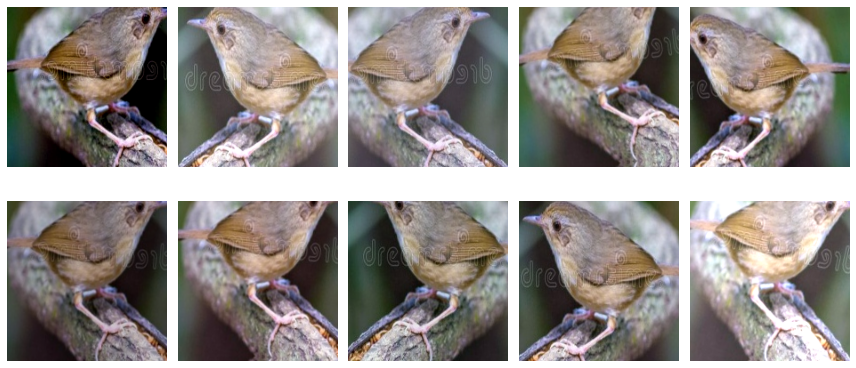

In [32]:
import copy


def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = TransformAdapter([A.Compose([t for t in dataset.transform.transforms[0] if not isinstance(t, (A.Normalize, ToTensorV2))])])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        _, image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_augmentations(train_dataset, idx=1)

Let's train model with augmentations, using pretrained weights.

Loading pre-trained weights
Fine-tuning all layers...
Epoch 1 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 2.231, training acc: 59.932
Validation loss: 0.323, validation acc: 93.300
--------------------------------------------------
Epoch 2 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.552, training acc: 87.491
Validation loss: 0.153, validation acc: 96.150
--------------------------------------------------
Epoch 3 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.343, training acc: 91.534
Validation loss: 0.099, validation acc: 97.600
--------------------------------------------------
Epoch 4 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.252, training acc: 93.516
Validation loss: 0.089, validation acc: 97.800
--------------------------------------------------
Epoch 5 of 5
Training


  0%|          | 0/3650 [00:00<?, ?it/s]

Validation


  0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.196, training acc: 94.876
Validation loss: 0.078, validation acc: 98.200
--------------------------------------------------


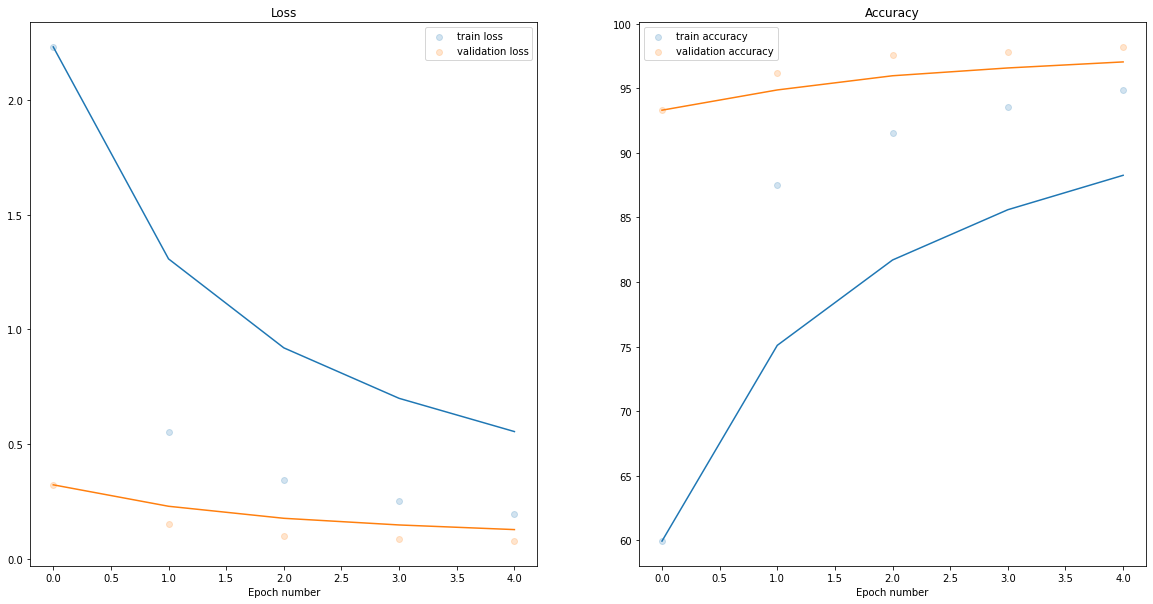

In [33]:
config_fine_tune_augment = {
    "lr": 0.0001,
    "epochs": 5,
    "path_to_checkpoint": "outputs/model_fine_tuned_augment.pth",
    "is_pretrained": True
}

model = build_model(
    pretrained=True,
    fine_tune=True,
    num_classes=len(classes)
).to(device)

train(model, **config_fine_tune_augment)

In [34]:
evaluate(model, device, test_data_loader, classes)

  0%|          | 0/125 [00:00<?, ?it/s]

Accuracy:  0.991
Classification report:
                             precision    recall  f1-score   support

            ABBOTTS BABBLER       1.00      1.00      1.00         5
              ABBOTTS BOOBY       1.00      1.00      1.00         5
 ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
      AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
     AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
          AFRICAN FIREFINCH       1.00      0.80      0.89         5
     AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
                  ALBATROSS       1.00      1.00      1.00         5
             ALBERTS TOWHEE       1.00      1.00      1.00         5
       ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
              ALPINE CHOUGH       1.00      1.00      1.00         5
      ALTAMIRA YELLOWTHROAT       1.00      0.80      0.89         5
            AMERICAN AVOCET       1.00      1.00      1.00    

We have 0.0015 improvement in accuracy (0.9895 vs. 0.991). It's not too much, the reason can be that we used hand-crafted augmentation pipeline.

If we use AutoAugment technique ([link to paper](https://arxiv.org/pdf/1911.06987.pdf)), probably we will get bigger improvement.
Basic idea of AutoAugment is to use GAN. After training Generator can produce augmented images that are indistinguishable from the main dataset by Discriminator.

Side note: using augmentations from Albumentations library, we get 2x increase in training speed compared to torchvision transforms.

## 5. Conclusions

We used 3 different approaches to train image classifier on "BIRDS 400 - SPECIES IMAGE CLASSIFICATION" dataset:
1. Training EfficientNet-B0 from scratch.
2. Fine-tuning EfficientNet-B0 on our dataset.
3. Fine-tuning EfficientNet-B0 on our dataset with data augmentation.

We can see that the 3rd approach gives the best model using just 5 epochs of training. So we can conclude that *Transfer learning* is a powerful technique for solving image classification problem. Also we saw that hand-crafted augmentations don't give much improvement from base result, but with augmentations we were able to get better model anyway.